In [89]:
#Importing libraries

#Importing basic libraries
import pandas as pd
import numpy as np
import warnings

#Data visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

#Modules necessary for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

#Modules necessary for context-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Setting display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Ignoring warnings
warnings.filterwarnings(action='ignore')

In [130]:
# Importing Data
anime_data = pd.read_csv('anime-filtered.csv', low_memory = False)
anime_data.head()

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108


In [35]:
data.shape #To find the number of rows and columns

(35305695, 13)

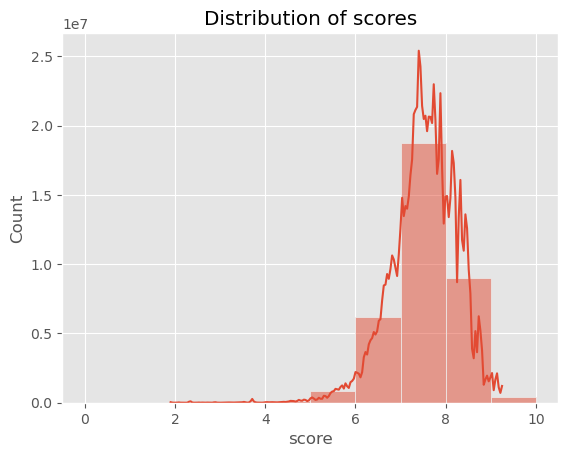

In [33]:
sns.histplot(x = data['score'], kde = True, bins = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title('Distribution of scores')
plt.show()

The distibution of scores show that majority of users rate animes highly. The mean ratings is ~7.6. 

In [132]:
#Checking for missing values
data_rec = anime_data[['Name', 'Score', 'Genres']]
data_rec.head()

,Name,Score,Genres
0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space"
2,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ..."
4,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural"


In [134]:
#Checking for duplicated entries
data_rec.isna().sum()

Name      0
Score     0
Genres    0
dtype: int64

In [140]:
#Create a TF-IDF vectorizer

tfidf = TfidfVectorizer(stop_words = 'english')

#Define a generator and compute the TF-IDF matrix
tfidf_matrix_gen = tfidf.fit_transform((genre for genre in data_rec['Genres'].values.astype('U')))

#Compute Cosine similarity
cosine_sim_sparse = linear_kernel(tfidf_matrix_gen, tfidf_matrix_gen)

In [188]:
#Function to get recommendations based on the cosine similarity, genre and ratings based on score
def get_recommendations(title, cosine_sim, df):
    '''
    Input:
    title: The title of the anime in english to generate simialr recommendations
    cosin_sim: precalcualted cosine similarity sparse matrix
    df: the database of animes

    Output:
    rec_animes: Dataframe of the top 10 similar animes.
    '''
    idx = df[df['Name'] == title].index[0]

    #Compute the similarity scores between the anime at the given index ann all other animes
    sim_score = list(enumerate(cosine_sim[idx]))

    #Filter animes without scores
    valid_scores = [x for x in sim_score if df.iloc[x[0]]['Score'] != 'UNKNOWN']

    #Sort the valid scores based on the cosine similarity and ratings score
    sorted_scores = sorted(valid_scores, key = lambda x: (x[1], df.iloc[x[0]]['Score']), reverse = True)

    #Get top 10 similar animes
    top_animes = [x for x in sorted_scores if x[0] != idx][: 10]

    #Extract the indices of the recommended animes
    rec_indices = [idx for idx, _ in top_animes]
    rec_animes = df.iloc[rec_indices][['Name', 'Genres', 'Score']]

    return rec_animes

In [199]:
anime_title = 'Magi: The Kingdom of Magic'
recomendations = get_recommendations(anime_title, cosine_sim_sparse, anime_data)
print('Recommendations for {}'.format(anime_title))
recomendations

Recommendations for Magi: The Kingdom of Magic


,Name,Genres,Score
7115,Magi: The Labyrinth of Magic,"Action, Adventure, Fantasy, Magic, Shounen",8.07
10499,Magi: Sinbad no Bouken (TV),"Action, Adventure, Fantasy, Magic, Shounen",7.91
8481,Magi: Sinbad no Bouken,"Action, Adventure, Fantasy, Magic, Shounen",7.85
5223,Densetsu no Yuusha no Densetsu,"Action, Adventure, Magic, Fantasy, Shounen",7.60
11304,Chain Chronicle: Haecceitas no Hikari Part 3,"Action, Adventure, Fantasy, Magic, Shounen",7.08
11303,Chain Chronicle: Haecceitas no Hikari Part 2,"Action, Adventure, Fantasy, Magic, Shounen",7.07
11302,Chain Chronicle: Haecceitas no Hikari Part 1,"Action, Adventure, Fantasy, Magic, Shounen",7.06
8310,Imanara Maniau! Log Horizon,"Action, Adventure, Magic, Fantasy, Shounen",6.79
13065,Huan Jie Wang,"Action, Adventure, Magic, Fantasy, Shounen",6.60
5857,Densetsu no Yuusha no Densetsu: Iris Report,"Action, Adventure, Fantasy, Magic, Shounen",6.55
